In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# for download data
import os
import urllib.request
import tarfile

#import requests
import sys
import time
import shutil
import random
from tqdm import tqdm





from sklearn.metrics import (auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve, 
    roc_auc_score,
    log_loss,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    )
from sklearn.preprocessing import label_binarize
from collections import Counter

# --- Pytorch--
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset


import torch.nn.functional as F


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device used is {device}")

Device used is cpu


In [4]:
def set_seed(seed: int = 42)-> None:
    """Seed Python, NumPy, and PyTorch (CPU & all GPUs) """
    # ---- Python and NumPy ------------------------------------------
    random.seed(seed)
    np.random.seed(seed)
    
    # ---- PyTorch (CPU  &  GPU) -------------------------------------
    torch.manual_seed(seed)            
   

In [5]:
set_seed(42)


## Loading Data

In [7]:
#======================================================
# Loading the full dataset
#======================================================

# Dataset URL
URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# -----------------------------------------------------
# Project-relative data directories (os.path version)
# -----------------------------------------------------

data_dir = "../data"
raw_dir = os.path.join(data_dir, "raw")
extracted_dir = os.path.join(data_dir, "extracted")

# Create directories if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(extracted_dir, exist_ok=True)

# Archive path
cps_archive_path = os.path.join(raw_dir, "flower_photos.tgz")

# -----------------------------------------------------
# Download the dataset
# -----------------------------------------------------
if not os.path.exists(cps_archive_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(URL, cps_archive_path)

# -----------------------------------------------------
# Extract the dataset
# -----------------------------------------------------
with tarfile.open(cps_archive_path) as tar:
    tar.extractall(path=extracted_dir, filter="data")

# Dataset root folder
flowers_dir = os.path.join(extracted_dir, "flower_photos")

print("Flowers dataset folder ready at:", flowers_dir)

# -----------------------------------------------------
# List class folders (ignore LICENSE.txt)
# -----------------------------------------------------
class_dirs = sorted([
    name for name in os.listdir(flowers_dir)
    if os.path.isdir(os.path.join(flowers_dir, name))
])

print("Subfolders:", class_dirs)


Flowers dataset folder ready at: ../data\extracted\flower_photos
Subfolders: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [8]:
#======================================================
# Select two classes of flowers: Daisy and Sunflowers. 
#======================================================
target_classes = ["daisy", "sunflowers"]


#==============================================================
# Path to the new subset folder containing daisy and sunflowers
#==============================================================

# subset directory
subset_dir = os.path.join(data_dir, "subsets", "daisy_sunflowers")
os.makedirs(subset_dir, exist_ok=True)

print(f"Path created: {subset_dir}")

for cls in target_classes:
    # source: original class folder
    src = os.path.join(flowers_dir, cls)
    
    # destination: subset class folder
    dst = os.path.join(subset_dir, cls)

    # Check if we already copied them to avoid doing it twice
    if not os.path.exists(dst):
        print(f"Copying {cls} folder to subset...")
        shutil.copytree(src, dst)
        print(f"{cls} is ready!")
    else:
        print(f"{cls} folder already exists in the subset.")

#--------------------------------------------------------------
# Load dataset
#--------------------------------------------------------------
daisysun_dataset = datasets.ImageFolder(
    root=subset_dir
)
print("=================================================")
print("Classes:", daisysun_dataset.classes)
print("=================================================")
print("Class to index:", daisysun_dataset.class_to_idx)
print("=================================================")
print("Number of images:", len(daisysun_dataset))

Path created: ../data\subsets\daisy_sunflowers
daisy folder already exists in the subset.
sunflowers folder already exists in the subset.
Classes: ['daisy', 'sunflowers']
Class to index: {'daisy': 0, 'sunflowers': 1}
Number of images: 1332


In [9]:
for cls in target_classes:
    class_dir = os.path.join(subset_dir, cls)

    formats = Counter(
        os.path.splitext(fname)[1].lower()
        for fname in os.listdir(class_dir)
        if os.path.isfile(os.path.join(class_dir, fname))
    )

    print(f"\nImage formats in '{cls}':")
    for ext, count in formats.items():
        print(f"  {ext}: {count}")


Image formats in 'daisy':
  .jpg: 633

Image formats in 'sunflowers':
  .jpg: 699


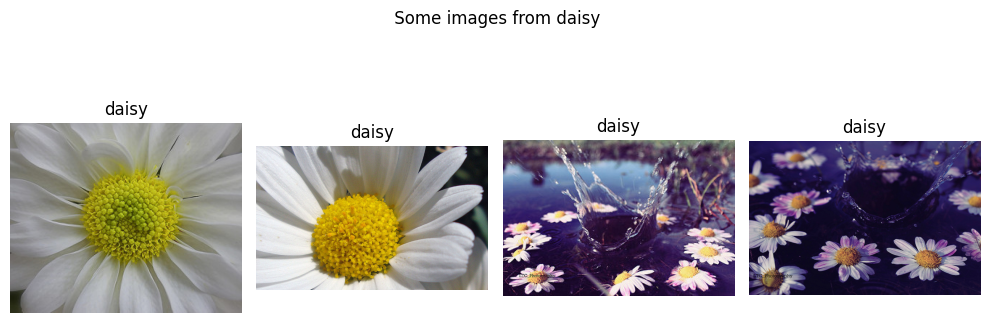

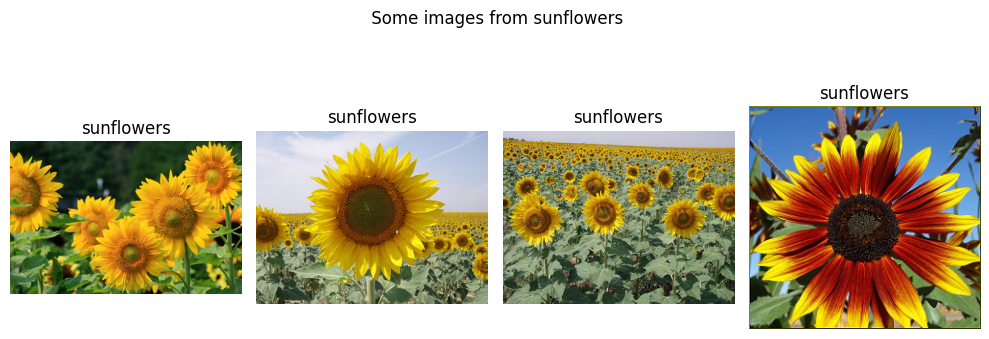

In [10]:
#======================================================================================================
# Select some pictures
#======================================================================================================
for cls in target_classes:
    class_dir = os.path.join(subset_dir, cls)


    # List only image files
    files = [f for f in os.listdir(class_dir)]

    # Select first 3 images (or change number)
    files = files[: 4]

    # Plot
    plt.figure(figsize=(10, 4))

    for i, filename in enumerate(files):
        img_path = os.path.join(class_dir, filename)
        img = Image.open(img_path)

        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{cls}")

    plt.suptitle(f" Some images from {cls}")
    plt.tight_layout()
    plt.show()


## Preprocessing Data 

### Hyperparameters 

In [11]:
#===================================================================
# Define the hyperparameters
#===================================================================
img_size = 128
batch_size = 64
epochs = 30
num_classes = 2  #number of classes in the dataset 5


### Transformation

In [12]:
train_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                       transforms.RandomRotation(20),
                                        transforms.RandomHorizontalFlip(p = 0.5),
                                        transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.8,1.2), shear=10),
                                        transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                        transforms.ToTensor(),  # Converts PIL Image to a tensor and scales values to [0, 1]
                                        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
                                        ])



# validation doesn´t transform
val_transform = transforms.Compose([
                 transforms.Resize((img_size, img_size)),
                 transforms.ToTensor(),
                 transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
 ])

## Split data into Train,  Validation and Test

In [13]:
#======================================================================================================
# Split data
#======================================================================================================

total_size = len(daisysun_dataset)
train_size = int(0.6 * total_size)  # 60%
val_size = int(0.2 * total_size)    # 20 %
test_size = total_size - train_size - val_size # 20%


# Generate indices and split them
indices = list(range(total_size))
np.random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create Subset
class ApplyTransform(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)


# Create the  datasets
train_dataset = ApplyTransform(Subset(daisysun_dataset, train_indices), transform=train_transform)
val_dataset = ApplyTransform(Subset(daisysun_dataset, val_indices), transform=val_transform)
test_dataset = ApplyTransform(Subset(daisysun_dataset, test_indices), transform=val_transform)




In [14]:
#======================================================================================================
# DataLoaders
#======================================================================================================
train_loader = torch.utils.data.DataLoader(train_dataset, 
                          batch_size = batch_size,
                          shuffle=True,
                         )


# Validation Data Loader
val_loader   = torch.utils.data.DataLoader(val_dataset,   
                                           batch_size=batch_size, 
                                           shuffle=False,  
                                        )
                                           


In [15]:
#======================================================================================================
# Define the model
#======================================================================================================

class FlowersCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(256),
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



In [16]:
#======================================================================================================
# Train the model
#======================================================================================================

def train_model(model, optimizer, criterion, train_loader, val_loader, device, epochs):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_val = float('inf')

    model.to(device)

    for epoch in range(epochs):
       
        # ---- Training ----
        model.train()
        running_loss = 0.0 
        correct = 0 
        total = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc  = correct / total

        # ---- Validation ----
        model.eval()
        val_loss_run = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)

                val_loss_run += criterion(logits, y).item()
                preds = logits.argmax(1)
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

        val_loss = val_loss_run / len(val_loader)
        val_acc  = val_correct / val_total

        scheduler.step(val_loss)

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if val_loss < best_val:
            best_val = val_loss

        print(f"Epoch {epoch+1}/{epochs} | "
              f"T_Loss: {train_loss:.4f} Val_Loss: {val_loss:.4f} | "
              f"T_Acc: {train_acc:.3f} Val_Acc: {val_acc:.3f}")

    return history




In [17]:
#======================================================================================================
# CrossEntropy and  Adam optimazer
#======================================================================================================

model_adam = FlowersCNN(num_classes).to(device)
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=5e-4,  weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_adam, 'min', patience=3, factor=0.5)


adam_history = train_model(
    model_adam, optimizer_adam, criterion,
    train_loader, val_loader,
    device, epochs=30
)



Epoch 1/30 | T_Loss: 0.4048 Val_Loss: 0.6305 | T_Acc: 0.819 Val_Acc: 0.602
Epoch 2/30 | T_Loss: 0.2981 Val_Loss: 0.3329 | T_Acc: 0.881 Val_Acc: 0.872
Epoch 3/30 | T_Loss: 0.2359 Val_Loss: 0.2631 | T_Acc: 0.914 Val_Acc: 0.891
Epoch 4/30 | T_Loss: 0.2042 Val_Loss: 0.3145 | T_Acc: 0.924 Val_Acc: 0.846
Epoch 5/30 | T_Loss: 0.1850 Val_Loss: 0.1487 | T_Acc: 0.927 Val_Acc: 0.947
Epoch 6/30 | T_Loss: 0.1788 Val_Loss: 0.1004 | T_Acc: 0.932 Val_Acc: 0.955
Epoch 7/30 | T_Loss: 0.1582 Val_Loss: 0.1463 | T_Acc: 0.940 Val_Acc: 0.932
Epoch 8/30 | T_Loss: 0.1678 Val_Loss: 0.1001 | T_Acc: 0.945 Val_Acc: 0.951
Epoch 9/30 | T_Loss: 0.1645 Val_Loss: 0.1399 | T_Acc: 0.941 Val_Acc: 0.936
Epoch 10/30 | T_Loss: 0.1707 Val_Loss: 0.1002 | T_Acc: 0.934 Val_Acc: 0.970
Epoch 11/30 | T_Loss: 0.1598 Val_Loss: 0.1328 | T_Acc: 0.940 Val_Acc: 0.951
Epoch 12/30 | T_Loss: 0.1346 Val_Loss: 0.0789 | T_Acc: 0.950 Val_Acc: 0.966
Epoch 13/30 | T_Loss: 0.1148 Val_Loss: 0.0731 | T_Acc: 0.957 Val_Acc: 0.977
Epoch 14/30 | T_Loss:

In [18]:
#======================================================================================================
# CrossEntropy and  SGD optimazer
#======================================================================================================

model_sgd = FlowersCNN(num_classes).to(device)

optimizer_sgd = torch.optim.SGD(
    model_sgd.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-3
)


scheduler_sgd = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_sgd, 
    mode='min', 
    patience=3, 
    factor=0.5
)


criterion = nn.CrossEntropyLoss()

sgd_history = train_model(
    model_sgd, optimizer_sgd, criterion,
    train_loader, val_loader,
    device, epochs=30
)


Epoch 1/30 | T_Loss: 0.4376 Val_Loss: 0.5191 | T_Acc: 0.786 Val_Acc: 0.763
Epoch 2/30 | T_Loss: 0.3099 Val_Loss: 0.2728 | T_Acc: 0.861 Val_Acc: 0.876
Epoch 3/30 | T_Loss: 0.2672 Val_Loss: 0.2610 | T_Acc: 0.885 Val_Acc: 0.887
Epoch 4/30 | T_Loss: 0.2111 Val_Loss: 0.1589 | T_Acc: 0.911 Val_Acc: 0.921
Epoch 5/30 | T_Loss: 0.2385 Val_Loss: 0.1905 | T_Acc: 0.911 Val_Acc: 0.921
Epoch 6/30 | T_Loss: 0.2283 Val_Loss: 0.1569 | T_Acc: 0.905 Val_Acc: 0.929
Epoch 7/30 | T_Loss: 0.1770 Val_Loss: 0.1382 | T_Acc: 0.931 Val_Acc: 0.925
Epoch 8/30 | T_Loss: 0.1915 Val_Loss: 0.3126 | T_Acc: 0.921 Val_Acc: 0.902
Epoch 9/30 | T_Loss: 0.1848 Val_Loss: 0.1622 | T_Acc: 0.942 Val_Acc: 0.921
Epoch 10/30 | T_Loss: 0.2054 Val_Loss: 0.1038 | T_Acc: 0.912 Val_Acc: 0.959
Epoch 11/30 | T_Loss: 0.1760 Val_Loss: 0.1196 | T_Acc: 0.929 Val_Acc: 0.940
Epoch 12/30 | T_Loss: 0.1552 Val_Loss: 0.1022 | T_Acc: 0.935 Val_Acc: 0.966
Epoch 13/30 | T_Loss: 0.1456 Val_Loss: 0.1359 | T_Acc: 0.945 Val_Acc: 0.936
Epoch 14/30 | T_Loss:

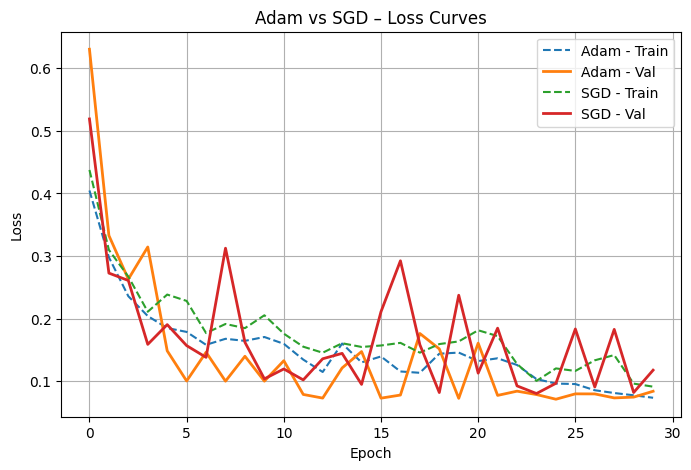

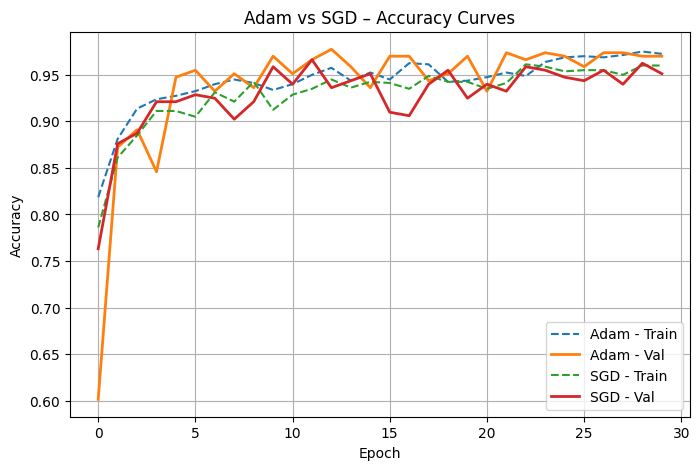

In [18]:
# ---------------------------------------------------------
#  Function to plot the curves
# ---------------------------------------------------------
def plot_metric(adam_history, sgd_history, metric, ylabel, title):
    plt.figure(figsize=(8,5))

    # Adam curves
    plt.plot(adam_history[f"train_{metric}"], label="Adam - Train", linestyle="--")
    plt.plot(adam_history[f"val_{metric}"], label="Adam - Val", linewidth=2)

    # SGD curves
    plt.plot(sgd_history[f"train_{metric}"], label="SGD - Train", linestyle="--")
    plt.plot(sgd_history[f"val_{metric}"], label="SGD - Val", linewidth=2)

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------------------------------------------------
# Plot Loss comparison (Train + Validation)
# ---------------------------------------------------------
plot_metric(
    adam_history, sgd_history,
    metric="loss",
    ylabel="Loss",
    title="Adam vs SGD – Loss Curves"
)

# ---------------------------------------------------------
# Plot Accuracy comparison (Train + Validation)
# ---------------------------------------------------------
plot_metric(
    adam_history, sgd_history,
    metric="acc",
    ylabel="Accuracy",
    title="Adam vs SGD – Accuracy Curves"
)



The loss plots show that:

* Adam has a lower validation loss curve. Althoug the differences are very tiny.

* The loss curve for SGD are more spikes that in the Adam´s case. 

* The train loss curves and validation loss curves decrease almost to the same ratio, indicating that the model is doing well learning patterns. The gap between them is not large, so there is no severe overfitting.

The accuracy plots:
* The validation accuracy for Adam optimization is a little higher than for the SGD 

* Both accuracies increase and reach a plateau around 10 epochs, indicating that the model has achieved its best performance.

* No overfitting.

Based on these results, I decided to continue with Adam optimization. 


In [19]:
# ---------------------------------------------------------
# Predictions for Adam optimization
# ---------------------------------------------------------
predictions = []
targets = []  # true labels

model_adam.eval()
with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(device)

        logits = model_adam(x_batch)
        batch_preds = logits.argmax(1)

        predictions.extend(batch_preds.cpu().tolist())
        targets.extend(y_batch.tolist())


In [20]:
accuracy = accuracy_score(targets, predictions)
print(f"The accuracy of the model is: {accuracy:.4f}")

The accuracy of the model is: 0.9699


In [21]:
# ---------------------------------------------------------
# Test
# ---------------------------------------------------------

# Data loader for test partition
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Ensure model and data share the same device
model_adam.to(device)
model_adam.eval()

num_correct = 0
num_samples = 0

pred_list   = []  # predicted 
label_list  = []  #true labels
prob_list   = []   # for class-1 probabilities

with torch.no_grad():     # evaluation uses no gradients
    for xt, yt in test_loader:
        
        xt, yt = xt.to(device), yt.to(device)

        # Forward pass
        logits = model_adam(xt)

        # Get probability of positive class (class index 1)
        class1_prob = F.softmax(logits, dim=1)[:, 1]

        # Predicted class index
        preds = logits.argmax(1)

        # Update accuracy counters
        num_samples += yt.size(0)
        num_correct += (preds == yt).sum().item()

        #  store predictions and labels
        pred_list.extend(preds.cpu().tolist())
        label_list.extend(yt.cpu().tolist())
        prob_list.extend(class1_prob.cpu().tolist())


# Final test accuracy
test_acc = 100 * num_correct / num_samples
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 96.63%


In [22]:
y_true = label_list
y_pred = pred_list
y_prob = prob_list

# ---------------------------------------------------------
# Evaluations metrics
# ---------------------------------------------------------
# Accuracy
accuracy = accuracy_score(y_true =y_true, y_pred = pred_list) 

# ROC-AUC (for predicted probabilities)
roc_auc = roc_auc_score(y_true = y_true,  y_score = prob_list)

# Binary Cross-Entropy Loss (for predicted probabilities)
loss = log_loss(y_true = label_list, y_pred = pred_list)

print(f"Evaluation metrics for the model:")

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"ROC-AUC: {roc_auc:.3f}")
print(f"Log Loss: {loss:.4f}")
print()
print(f"Classification report:")
print(classification_report(y_true = label_list,  y_pred = pred_list , target_names = ["daisy", "sunflowers"]))





Evaluation metrics for the model:
Accuracy: 96.63%
ROC-AUC: 0.995
Log Loss: 1.2150

Classification report:
              precision    recall  f1-score   support

       daisy       0.94      0.99      0.96       117
  sunflowers       0.99      0.95      0.97       150

    accuracy                           0.97       267
   macro avg       0.96      0.97      0.97       267
weighted avg       0.97      0.97      0.97       267



[[116   1]
 [  8 142]]


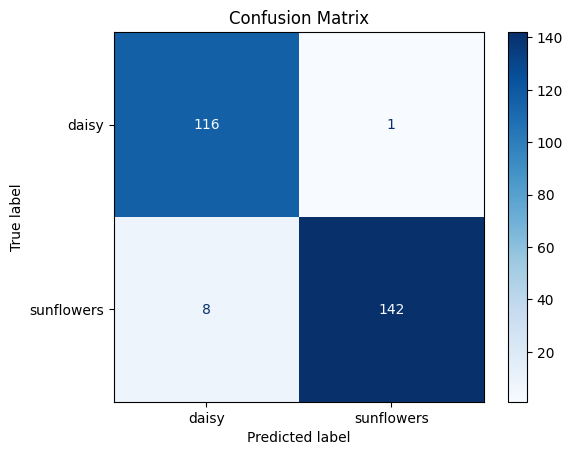

In [23]:
cm = confusion_matrix(y_true = label_list,  y_pred = pred_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= target_classes)


#print("Confusion matrix")
print(disp.confusion_matrix)

# Plot the matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


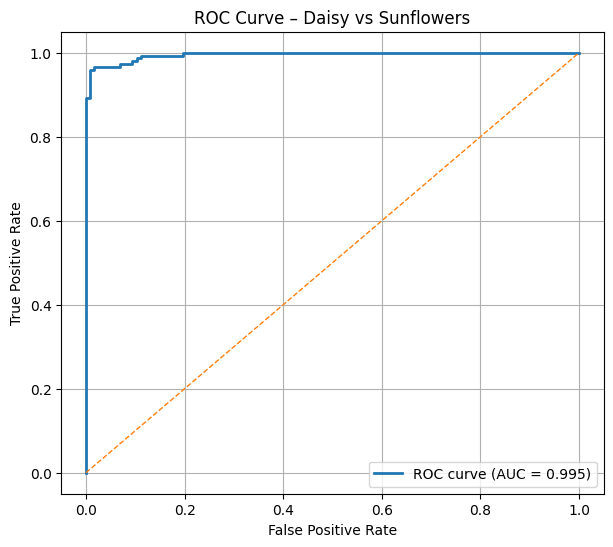

In [24]:
# ---------------------------------------------------------
# ROC curve
# ---------------------------------------------------------


fpr, tpr, thresholds = roc_curve(label_list, prob_list)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Daisy vs Sunflowers")
plt.legend()
plt.grid(True)
plt.show()



Found 9 misclassified samples.



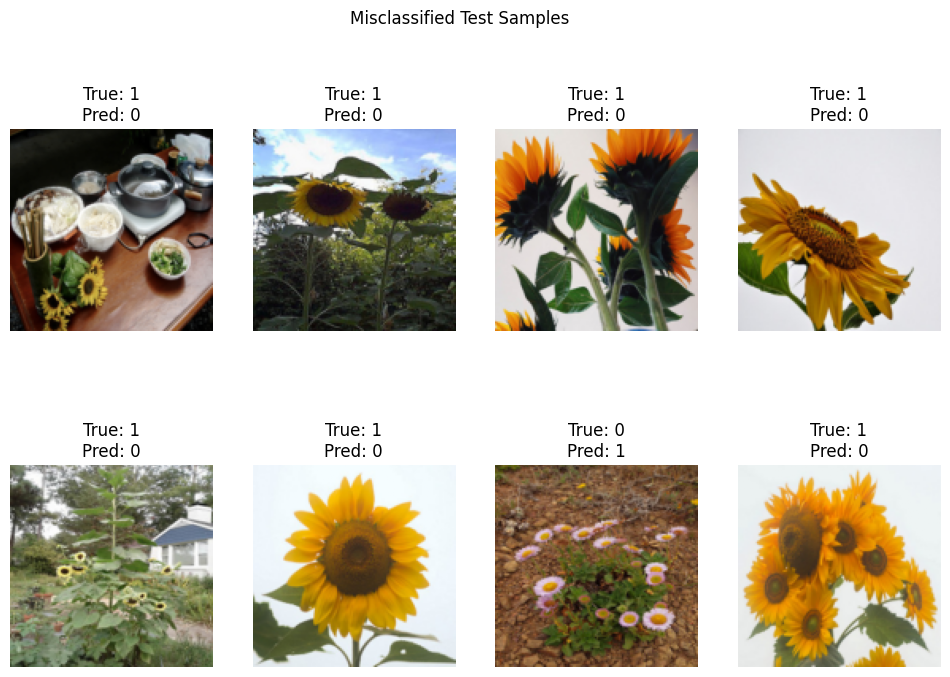

In [25]:
# ---------------------------------------------------------
# See  some misclassifications
# ---------------------------------------------------------

model_adam.eval()

misclassified_images = []
misclassified_true = []
misclassified_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_adam(images)
        _, preds = torch.max(outputs, 1)

        # find indices where prediction is wrong
        wrong = preds != labels

        if wrong.any():
            misclassified_images.extend(images[wrong].cpu())
            misclassified_true.extend(labels[wrong].cpu().numpy())
            misclassified_pred.extend(preds[wrong].cpu().numpy())

# If no misclassifications
if len(misclassified_images) == 0:
    print("🎉 No misclassified samples found in the test set!")
else:
    print(f"Found {len(misclassified_images)} misclassified samples.\n")

    # Plot first 8 misclassified samples
    num_to_show = min(8, len(misclassified_images))

    plt.figure(figsize=(12, 8))
    for i in range(num_to_show):
        img = misclassified_images[i]
        true_label = misclassified_true[i]
        pred_label = misclassified_pred[i]

        img = img.permute(1, 2, 0)  # CHW → HWC
        img = img * torch.tensor([0.5, 0.5, 0.5]) + torch.tensor([0.5, 0.5, 0.5])  # unnormalize
        img = img.clamp(0, 1)

        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {true_label}\nPred: {pred_label}")

    plt.suptitle("Misclassified Test Samples")
    plt.show()


## Acknowledgments

Thanks to the IBM course  "AI Capstone Project with Deep Learning course", which helped me understand several supporting ideas used in this project. While the model  and analyses were developed independently as part of my own learning process, the utility functions   "set_seed()" and the "misclassified-image display" were  copied from some of the ungraded labs provided in the *IBM AI Capstone Project with Deep Learning* were these utilities were part of the learning material. Addinianlly,  the *generator-based data loading code* was adapted to fit my dataset. 

Special thanks to all the photographers associated to the Flowers dataset. 



